In [156]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, roc_curve
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline as ImPipeline

In [157]:
data = pd.read_csv('clean_data.csv')

>- Please refer to the [EDA](https://github.com/Danayt09/Tanzanian_Water_Wells/blob/main/EDA.ipynb) notebook for the cleaning process towards the final data.
>- Data had repetative columns with similar information and duplicated were removed
>- Missing values were imputed with either median or mean for numeric columns and with frequent value for categorical

In [158]:
# constraction year and age of well are correlated and convey the same information
#id will also not help our model's prediction so will drop it for now
data = data.drop(['construction_year', 'id'], axis=1)

In [159]:
data.funder.value_counts(normalize=True)

funder
Others                    0.659356
Government Of Tanzania    0.153539
unknown                   0.076440
Danida                    0.054074
Hesawa                    0.033236
World Bank                0.023356
Name: proportion, dtype: float64

In [160]:
data.installer.value_counts(normalize=True)

installer
Others        0.573158
DWE           0.282264
unknown       0.076665
Government    0.028999
RWE           0.020508
Community     0.018407
Name: proportion, dtype: float64

In [161]:
# More than 50% of funder and installer are grouped as others and this isn't helpful information for our model
# I'll try the model with both and try removing them to see performance increase

In [162]:
# Changing all T/F columns 
bool_columns = data.select_dtypes(include=bool).columns
data[bool_columns] = data[bool_columns].astype(int)

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57588 entries, 0 to 57587
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funder                 57588 non-null  object 
 1   gps_height             57588 non-null  float64
 2   installer              57588 non-null  object 
 3   longitude              57588 non-null  float64
 4   latitude               57588 non-null  float64
 5   basin                  57588 non-null  object 
 6   population             57588 non-null  float64
 7   public_meeting         57588 non-null  int64  
 8   permit                 57588 non-null  int64  
 9   extraction_type_class  57588 non-null  object 
 10  management_group       57588 non-null  object 
 11  payment                57588 non-null  object 
 12  water_quality          57588 non-null  object 
 13  quantity               57588 non-null  object 
 14  source                 57588 non-null  object 
 15  so

# Preprocessing
### Target 
>- 0 = Non functional
>- 1 = Functional but needs repair
>- 2 = Functional

In [164]:
data.status_group.value_counts(normalize=True)

status_group
2    0.545061
0    0.386678
1    0.068261
Name: proportion, dtype: float64

In [165]:
X= data.drop('status_group', axis =1)
y= data['status_group']

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

>- Seperating categorical, numeric and binary columns
>- Have our columns pass through a transformer
>- Impute missing values and one hot encode

In [167]:
cat_cols = ['installer', 'funder', 'basin', 'management_group', 'extraction_type_class', 'payment', 'water_quality', 
              'quantity', 'source', 'source_class', 'waterpoint_type_group']

num_cols = ['gps_height', 'population', 'age_of_well', 'permit', 'public_meeting']

In [168]:
# A data frame to save results in
results = pd.DataFrame(columns=["Model", 'val_score',"test_balanced_acc",
                                   'train_balanced_acc', 'logloss','info','param'])

In [169]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
    
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(add_indicator=True, strategy='median')),
    ('scaler', StandardScaler())
])

In [170]:
test = selector(dtype_include=object)
test(X)

['funder',
 'installer',
 'basin',
 'extraction_type_class',
 'management_group',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type_group']

In [171]:
numtest = selector(dtype_include=np.number)
numtest(X)

['gps_height',
 'longitude',
 'latitude',
 'population',
 'public_meeting',
 'permit',
 'age_of_well']

In [172]:
CT = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numerical_transformer, num_cols)
    ], remainder='passthrough')

# Baseline model using a dummyregressor
>- Our baseline performed at 54% accuracy and 33% balanced accuracy
>- This makes sence as we've huge class imbalance and it's predicting true for all majority class #2
>- Next model will be Logistic regression

In [173]:
dummy_model = Pipeline(steps=[
    ('ct',CT),
    ('dummy',DummyClassifier(strategy='most_frequent', random_state=42))
]CT

In [174]:
dummy_model.fit(X_train, y_train)

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'funder',
                                                   'basin', 'management_group',
                                                   'extraction_type_class',
                                                   'payment', 'water_quality',
                                                   'quantity', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'population',
                                                   'age_of_well', 'permit',
                                                   'public_meeting'])])),
                ('dummy',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])

In [175]:
dummy_cv = cross_val_score(dummy_model, X_train, y_train, cv=5)
dummy_cv

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

array([0.5444975 , 0.5444975 , 0.54460603, 0.54460603, 0.54460603])

In [176]:
baseline_logloss = -1*(cross_val_score(estimator=dummy_model, X=X_train, y=y_train, scoring="neg_log_loss").mean())
baseline_logloss

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: Fu

16.41562698959097

In [177]:
y_train_1 = dummy_model.predict(X_train)
y_test_pred1= dummy_model.predict(X_test)

print("Accuracy:")
train_accuracy = accuracy_score(y_train, y_train_1)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred1)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_train, y_train_1)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_test, y_test_pred1)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.5445626220968092
Test Accuracy: 0.5470567806910922

Balanced Accuracy:
Train Accuracy: 0.3333333333333333
Test Accuracy: 0.3333333333333333


/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4426
           1       0.00      0.00      0.00       791
           2       0.55      1.00      0.71      6301

    accuracy                           0.55     11518
   macro avg       0.18      0.33      0.24     11518
weighted avg       0.30      0.55      0.39     11518



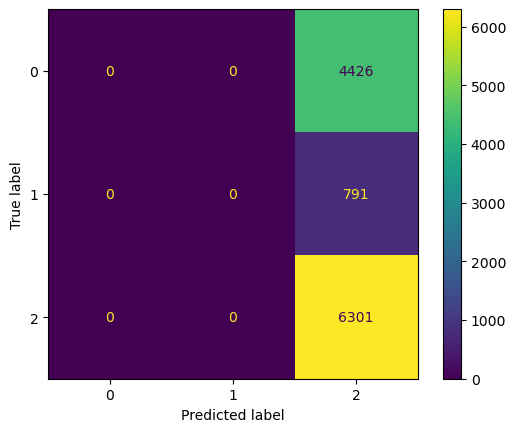

In [178]:
print(classification_report(y_test, y_test_pred1)) 
cm = confusion_matrix(y_test, y_test_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [184]:
#First model, baseline performance to record to our results table
results_1 = pd.DataFrame({       
     "Model": ['Dummyreggressor'],
    "val_score": [0.54],
      "test_balanced_acc": [0.33], 
       'train_balanced_acc' : [0.33],
    'logloss':[16.42],
               'info' : ['baseline'],
    'param':['Random_state=42, stg=Most_frequent']
})
results = pd.concat([results, results_1], ignore_index =True)

# Logistic Regression
>- This model performed significantly better than our baseline
>- But the balanced accuracy is still low, indicating our model is biased towards the majority class
>- We'll try different parameters and see if we can improve performance as well as class imbalance
>>-Train Accuracy: 0.7298241805947471
>>-Test Accuracy: 0.7257336343115124

>>-Train Accuracy: 0.5082261808855584
>>-Test Accuracy: 0.5055801344470208

In [182]:
lr1 = Pipeline(steps=[
    ('ct', CT),
    ('classifier', LogisticRegression(random_state =42, n_jobs=-1))
])

In [183]:
lr1.fit(X_train, y_train)

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'funder',
                                                   'basin', 'management_group',
                                                   'extraction_type_class',
                                                   'payment', 'water_quality',
                                                   'quantity', 'source',
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'population',
                                                   'age_of_well', 'permit',
                                                   'public_meeting'])])),
                ('classifier', LogisticRegression(n_jobs=-1, random_state=42))])

In [185]:
lr1_cv = cross_val_score(lr1, X_train, y_train, cv=5)
lr1_cv

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in 

array([0.73138702, 0.72628609, 0.72357282, 0.72889082, 0.73464293])

In [188]:
lr1_logloss = -1*(cross_val_score(estimator=lr1, X=X_train, y=y_train, scoring="neg_log_loss").mean())
lr1_logloss

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in 

0.6581956900813342

In [190]:
y_train_lr1 = lr1.predict(X_train)
y_test_pred_lr1= lr1.predict(X_test)

print("Accuracy:")
train_accuracy = accuracy_score(y_train, y_train_lr1)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred_lr1)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_train, y_train_lr1)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_test, y_test_pred_lr1)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.7298241805947471
Test Accuracy: 0.7257336343115124

Balanced Accuracy:
Train Accuracy: 0.5082261808855584
Test Accuracy: 0.5055801344470208


              precision    recall  f1-score   support

           0       0.78      0.60      0.68      4426
           1       0.55      0.01      0.03       791
           2       0.70      0.90      0.79      6301

    accuracy                           0.73     11518
   macro avg       0.68      0.51      0.50     11518
weighted avg       0.72      0.73      0.69     11518



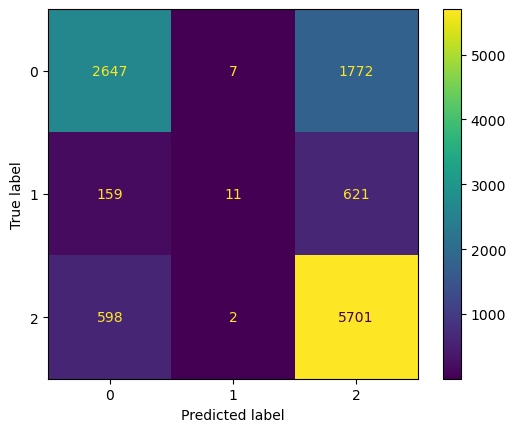

In [191]:
print(classification_report(y_test, y_test_pred_lr1)) 
cm = confusion_matrix(y_test, y_test_pred_lr1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [193]:
results_2 = pd.DataFrame({       
     "Model": ['LogisticRegression'],
    "val_score": [0.73],
      "test_balanced_acc": [0.508], 
       'train_balanced_acc' : [0.505],
    'logloss':[0.658],
               'info' : ['simple_lr'],
    'param':['Random_state=42']
})
results = pd.concat([results, results_2], ignore_index =True)

# Model Tunining 
>- will first look into the available parameters we can change and use the most applicable to our case
>- Creating another logistic regression with improved prameters
>- Will be srating with 'classifier__class_weight', 'classifier__multi_class', 'classifier__solver'
>- The results are lower for accuracy but we've balanced outcome with accuracy and balanced accuracy yielding similar results
>>-Train Accuracy: 0.630518775775993
>>-Test Accuracy: 0.6326619204723042

>>-Train Accuracy: 0.6149925249972608
>>-Test Accuracy: 0.6140623009408069
>- But we've an increased log loss and we'll need to try grid searching for best params

In [195]:
lr1.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ct', 'classifier', 'ct__n_jobs', 'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights', 'ct__transformers', 'ct__verbose', 'ct__verbose_feature_names_out', 'ct__cat', 'ct__num', 'ct__cat__memory', 'ct__cat__steps', 'ct__cat__verbose', 'ct__cat__imputer', 'ct__cat__encoder', 'ct__cat__imputer__add_indicator', 'ct__cat__imputer__copy', 'ct__cat__imputer__fill_value', 'ct__cat__imputer__keep_empty_features', 'ct__cat__imputer__missing_values', 'ct__cat__imputer__strategy', 'ct__cat__encoder__categories', 'ct__cat__encoder__drop', 'ct__cat__encoder__dtype', 'ct__cat__encoder__feature_name_combiner', 'ct__cat__encoder__handle_unknown', 'ct__cat__encoder__max_categories', 'ct__cat__encoder__min_frequency', 'ct__cat__encoder__sparse', 'ct__cat__encoder__sparse_output', 'ct__num__memory', 'ct__num__steps', 'ct__num__verbose', 'ct__num__imputer', 'ct__num__scaler', 'ct__num__imputer__add_indicator', 'ct__num__imputer__copy', 'ct__num__imput

In [199]:
lr2 = Pipeline(steps=[
    ('ct', CT),
    ('classifier', LogisticRegression(random_state =42, multi_class='multinomial', solver='saga', class_weight='balanced', n_jobs=-1))
])

In [200]:
lr2.fit(X_train, y_train)

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['installer', 'funder',
                                                   'basin', 'management_group',
                                                   'extraction_type_class',
                                                   'payment', 'water_quality',
                                                   'quantity', 's...
                                                   'source_class',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gps_height', 'population',
                                                   'age_of_well', 'permit',
                                                   'public_meeting'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced',
                                    multi_class='multinomial', n_jobs=-1,
                                    random_state=42, solver='saga'))])

In [207]:
lr2_cv = cross_val_score(lr2, X_train, y_train, cv=5)
lr2_cv

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/U

array([0.63164749, 0.62719774, 0.62969394, 0.63294986, 0.62958541])

In [204]:
lr2_logloss = -1*(cross_val_score(lr2, X_train, y_train, scoring="neg_log_loss").mean())
lr2_logloss

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/U

0.8369706664454093

In [205]:
y_train_lr2 = lr2.predict(X_train)
y_test_pred_lr2= lr2.predict(X_test)

print("Accuracy:")
train_accuracy = accuracy_score(y_train, y_train_lr2)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred_lr2)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_train, y_train_lr2)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_test, y_test_pred_lr2)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.630518775775993
Test Accuracy: 0.6326619204723042

Balanced Accuracy:
Train Accuracy: 0.6149925249972608
Test Accuracy: 0.6140623009408069


              precision    recall  f1-score   support

           0       0.78      0.60      0.68      4426
           1       0.17      0.58      0.26       791
           2       0.77      0.66      0.71      6301

    accuracy                           0.63     11518
   macro avg       0.57      0.61      0.55     11518
weighted avg       0.73      0.63      0.67     11518



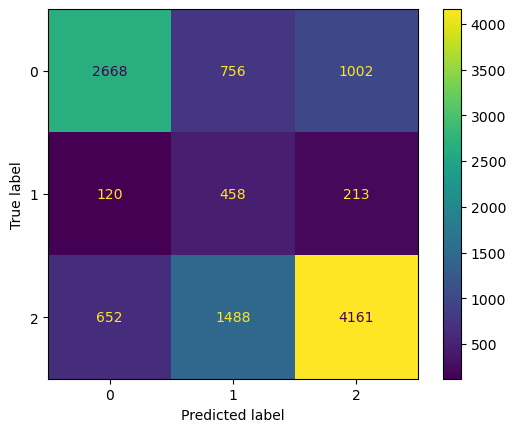

In [206]:
print(classification_report(y_test, y_test_pred_lr2)) 
cm = confusion_matrix(y_test, y_test_pred_lr2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [211]:
results_3 = pd.DataFrame({       
     "Model": ['LogisticRegression'],
    "val_score": [0.63],
      "test_balanced_acc": [0.615], 
       'train_balanced_acc' : [0.614],
    'logloss':[0.836],
               'info' : ['with_params'],
    'param':['multi_class: multinomial,class_weight: balanced,solver:saga']
})
results = pd.concat([results, results_3], ignore_index =True)

# Coefficifient

In [213]:
logreg = lr2.named_steps['classifier']

In [214]:
logreg_coef = logreg.coef_

In [215]:
column_names = lr2.named_steps['ct'].get_feature_names_out()

In [224]:
influential_columns = dict(zip(column_names, logreg_coef[0]))
influential_columns

{'cat__installer_Community': -0.605516500963481,
 'cat__installer_DWE': 0.03235550624135693,
 'cat__installer_Government': 0.20073648211599993,
 'cat__installer_Others': 0.2830694601539163,
 'cat__installer_RWE': 0.3004083443286926,
 'cat__installer_unknown': -0.2788448510979396,
 'cat__funder_Danida': -0.0515725114032116,
 'cat__funder_Government Of Tanzania': 0.16071559920597212,
 'cat__funder_Hesawa': -0.08842047105931082,
 'cat__funder_Others': -0.10831321625053557,
 'cat__funder_World Bank': 0.09905370437227741,
 'cat__funder_unknown': -0.07925466408678145,
 'cat__basin_Internal': -0.29837539058028933,
 'cat__basin_Lake Nyasa': 0.08399809147866391,
 'cat__basin_Lake Rukwa': 0.32232621179770543,
 'cat__basin_Lake Tanganyika': -0.04262502244411458,
 'cat__basin_Lake Victoria': -0.18586241007641152,
 'cat__basin_Pangani': 0.001273340200097901,
 'cat__basin_Rufiji': 0.1724609055215608,
 'cat__basin_Ruvuma / Southern Coast': -0.035981468302530746,
 'cat__basin_Wami / Ruvu': -0.08500581

In [222]:
sorted_columns = sorted(influential_columns.items(),
                        key=lambda x:abs(x[1]), reverse=True)

In [223]:
sorted_columns

[('cat__quantity_dry', 1.9827578745147545),
 ('cat__source_rainwater harvesting', -0.9537373416683752),
 ('cat__quantity_enough', -0.9150108666941584),
 ('cat__quantity_insufficient', -0.7474721691942042),
 ('cat__quantity_seasonal', -0.7276439514013757),
 ('cat__source_lake', 0.7235865961632946),
 ('cat__extraction_type_class_other', 0.6374352106176987),
 ('cat__waterpoint_type_group_improved spring', -0.6291368337369232),
 ('cat__installer_Community', -0.605516500963481),
 ('cat__source_dam', 0.5282787956971735),
 ('cat__source_hand dtw', 0.4874026046973853),
 ('cat__source_spring', -0.44199225327291464),
 ('cat__waterpoint_type_group_other', 0.4418261265743817),
 ('cat__payment_unknown', 0.40612349369982786),
 ('cat__quantity_unknown', 0.3395775535540183),
 ('cat__payment_never pay', 0.33673444422328813),
 ('cat__extraction_type_class_handpump', -0.3292885457110131),
 ('cat__extraction_type_class_gravity', -0.3257074699066874),
 ('cat__basin_Lake Rukwa', 0.32232621179770543),
 ('cat